In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

import warnings
import re
import os
import time
import pickle

%matplotlib inline

In [2]:
skl.__version__, sns.__version__, pd.__version__, np.__version__

('0.22.1', '0.10.0', '1.0.1', '1.18.1')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, get_scorer

from sklearn.externals import joblib

C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
from ML_helper_functions import *

In [5]:
warnings.filterwarnings(action='ignore')
sns.set_context('talk')

In [6]:
dpi = 200

# Get data, train models

## datamatrix loading

Load datamatrices

In [7]:
yXs = []

for i, name in enumerate(['dim', 'TD10', 'ring_size']):
    yx = joblib.load(f'yX_{name}.dtm')
    print(f'{name} data loaded: {yx.shape}')
    yXs.append(yx)

y1X, y2X, y4X = yXs

dim data loaded: (2860, 11)
TD10 data loaded: (579, 11)
ring_size data loaded: (505, 11)


In [8]:
y1X.head(2)

,dim,nConf20,RotRatio,HybRatio,TopoPSA,LabuteASA,IC1,BalabanJ,Kier3,NHOHCount,nHBAcc
[B1 F4 1-_(1)]_RUMTEZ..[F6 P1 1-_(0)]_RUMTAV|Ag Au_C2H6N[M1]*{107} C4H11N3[B2]{171928}_A)2*B2)2*M1,0.0,-0.053988,0.000000,0.034387,0.0,0.246370,-0.180427,0.317645,-0.054644,0.0,0.0
[C4 H12 N1 1+_(3)]_IDOFUF..[C8 H12 N1 1+_(2)]_EGECEB|Ag Bi_Br[M1]{17} Br[M2]{17}_A*M2)2*M1)2,0.0,0.000000,-0.555556,-0.750000,0.0,0.402284,0.249076,-0.051469,-0.404959,0.0,0.0


## Model training, tuning, assesment

**Model comparison using nested 5x5 cross-validation**

In [38]:
def eval_target(dm, parallel=-1, scoring='f1_macro'):

    lr = LogisticRegression(class_weight='balanced', penalty='l2', solver='liblinear')
    dt = DecisionTreeClassifier()
    rfc = RandomForestClassifier(class_weight='balanced')
    svm = SVC(probability=True, cache_size=750, class_weight='balanced')
    gbc = GradientBoostingClassifier()
    dmm = DummyClassifier()



    lr_param_grid = {'C': np.logspace(-3, 3, 7)}

    dt_param_grid = {'max_depth': list(range(4, 10)) + [None],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_leaf': [3, 4, 5]}

    rf_param_grid = {'n_estimators': (100, 250, 500),
                     'max_depth': (10, None)}

    svm_param_grid = {'kernel': ('rbf', ),
                      'C': np.logspace(-2, 2, 5),
                      'gamma': np.logspace(-4, 1, 6)}
                      
    gbc_param_grid = {'n_estimators': (100, 250, 500),
                      'max_depth': (2, 3),
                      'learning_rate': (0.25, 1.0, 5.0)}

    dmm_param_grid = {'strategy': ('stratified', 'most_frequent', 'uniform')}


    # for nested 5x5 cv and final model training
    X, y = dm.iloc[:, 1:], dm.iloc[:, 0].astype(int)

    # for checking straw models make Xij take values from [-1; 1)
#     np.random.seed(14)
#     X, y = 2*np.random.random_sample(dm.iloc[:, 1:].shape) - 1, dm.iloc[:, 0].astype(int) 

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=.2,
                                                        stratify=y,
                                                        random_state=23) # for model analysis



    # Setting up multiple GridSearchCV objects, 1 for each algorithm
    gridcvs = {}
    s5f = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)    

    for est, est_param, name in zip(
                                    (lr, dt, rfc, svm, gbc, dmm),
                                    (lr_param_grid, dt_param_grid, rf_param_grid, svm_param_grid, gbc_param_grid, dmm_param_grid),
                                    ('LR', 'DT', 'RF', 'SVC', 'GBC', 'DUM')
                                   ):

        gcv = GridSearchCV(estimator=est,
                           param_grid=est_param,
                           scoring=scoring,
                           n_jobs=parallel,
                           cv=s5f,
                           refit=True)
        gridcvs[name] = gcv

    Q = {}
    estimators = {}
    for name, gs_est in sorted(gridcvs.items()):
        start = time.time()
        nested_score = cross_val_score(gs_est,
                                       X=X,
                                       y=y,
                                       cv=s5f,
                                       scoring=scoring,
                                       n_jobs=parallel)
        print('Algorithm selection with nested cross-validation')
        print('Nested CV results: %-4s | outer %s |||%.2f%% +/- %.2f|||' % (name, scoring, nested_score.mean() * 100, nested_score.std() * 100))
        print('Time elapsed: %.3f sec' % (time.time() - start))
        print('\n')

        est_grid_cv = gridcvs[name]
        est_grid_cv.fit(X=X_train, y=y_train)
        print('%s %.2f%% (average over CV test folds)' % (scoring, 100 * est_grid_cv.best_score_))
        print('Best Parameters |||ALL DATA USED HERE|||: %s' % est_grid_cv.best_params_)
        print('Confusion matrix\n', confusion_matrix(y_test, est_grid_cv.best_estimator_.predict(X_test)))
        print('Classification Report\n', classification_report(y_test, est_grid_cv.best_estimator_.predict(X_test)))

        estimators[name] = est_grid_cv.predict(X_test)

        print('\n%s\n' % (70*'*'))


        Q[name] = [
                   nested_score.mean(), nested_score.std(),
                   est_grid_cv.best_params_,
                   confusion_matrix(y_test, est_grid_cv.best_estimator_.predict(X_test))
                  ]

        # Fitting a model to the whole dataset
        # using estimator with the "best" hyperparameter settings
        gridcvs[name] = est_grid_cv.best_estimator_.fit(X, y)

    return gridcvs, Q, estimators

In [39]:
# f1_macro
model_dicts = {}
model_quality = {}
estimators_trained_on_Xtrain = {}

for name, yx in zip(['dim', 'TD10', 'ring_size'], [y1X, y2X, y4X]):

    print('\n%s\n' % (70*'#'))
    print(name, 'prediction')
    print('\n%s\n' % (70*'#'))

    model_dicts[name], model_quality[name], estimators_trained_on_Xtrain[name] = eval_target(yx)


######################################################################

dim prediction

######################################################################

Algorithm selection with nested cross-validation
Nested CV results: DT   | outer f1_macro |||50.75% +/- 2.22|||
Time elapsed: 6.380 sec


f1_macro 50.40% (average over CV test folds)
Best Parameters |||ALL DATA USED HERE|||: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3}
Confusion matrix
 [[420  67]
 [ 74  11]]
Classification Report
               precision    recall  f1-score   support

           0       0.85      0.86      0.86       487
           1       0.14      0.13      0.13        85

    accuracy                           0.75       572
   macro avg       0.50      0.50      0.50       572
weighted avg       0.74      0.75      0.75       572


**********************************************************************

Algorithm selection with nested cross-validation
Nested CV results: DUM  | outer f1

Algorithm selection with nested cross-validation
Nested CV results: SVC  | outer f1_macro |||51.99% +/- 4.25|||
Time elapsed: 6.579 sec


f1_macro 52.19% (average over CV test folds)
Best Parameters |||ALL DATA USED HERE|||: {'C': 100.0, 'gamma': 0.0001, 'kernel': 'rbf'}
Confusion matrix
 [[44 17]
 [36 19]]
Classification Report
               precision    recall  f1-score   support

           0       0.55      0.72      0.62        61
           1       0.53      0.35      0.42        55

    accuracy                           0.54       116
   macro avg       0.54      0.53      0.52       116
weighted avg       0.54      0.54      0.53       116


**********************************************************************


######################################################################

ring_size prediction

######################################################################

Algorithm selection with nested cross-validation
Nested CV results: DT   | outer f1_macro |||48.84% +

In [40]:
joblib.dump(model_dicts, 'trained_models_Xtrue.pkl')
joblib.dump(model_quality, 'trained_models_q_data_Xtrue.pkl')

['trained_models_q_data_Xrand.pkl']

# Analyze models

## describe model performance

In [7]:
model_dicts_loaded = joblib.load('trained_models_Xtrue.pkl')
model_qs_loaded = joblib.load('trained_models_q_data_Xtrue.pkl')
yXs = []

for i, name in enumerate(['dim', 'TD10', 'ring_size']):
    yx = joblib.load(f'yX_{name}.dtm')
    print(f'{name} data loaded: {yx.shape}')
    yXs.append(yx)

y1X, y2X, y4X = yXs

dim data loaded: (2860, 11)
TD10 data loaded: (579, 11)
ring_size data loaded: (505, 11)


In [8]:
multidx = pd.MultiIndex.from_product([model_qs_loaded.keys(), model_qs_loaded['dim'].keys()])

summary = pd.DataFrame(index=multidx,
                       data=[model_qs_loaded[target][model] for target in model_qs_loaded.keys() for model in model_qs_loaded[target].keys()],
                       columns=['n5x5_cv_mean', 'n5x5_cv_std',
                                'best_params_',
                                'confusion_matrix']
                        )

In [9]:
summary['0_precision'] = summary['confusion_matrix'].apply(lambda x: x[0][0]/(x[0][0] + x[1][0]))
summary['0_recall'] = summary['confusion_matrix'].apply(lambda x: x[0][0]/(x[0][0] + x[0][1]))
summary['0_F1'] = (2 * summary['0_precision'] * summary['0_recall'])/(summary['0_precision'] + summary['0_recall'])

summary['1_precision'] = summary['confusion_matrix'].apply(lambda x: x[1][1]/(x[0][1] + x[1][1]))
summary['1_recall'] = summary['confusion_matrix'].apply(lambda x: x[1][1]/(x[1][0] + x[1][1]))
summary['1_F1'] = (2 * summary['1_precision'] * summary['1_recall'])/(summary['1_precision'] + summary['1_recall'])

summary['precision'] = (summary['0_precision'] + summary['1_precision'])/2
summary['recall'] = (summary['0_recall'] + summary['1_recall'])/2
summary['F1'] = (summary['0_F1'] + summary['1_F1'])/2

In [10]:
dq = summary.style\
            .format({k: '{:.1%}' for k in summary.dtypes[(summary.dtypes == 'float64')].index.values.tolist()})\
            .bar(subset=['n5x5_cv_mean',
                         '0_precision', '0_recall', '0_F1',
                         '1_precision', '1_recall', '1_F1',
                         'precision', 'recall', 'F1'], color='#2e8b57', vmin=0, vmax=1)
# dq.to_excel('models_new_Xtrue.xlsx', float_format='%.4f')
dq

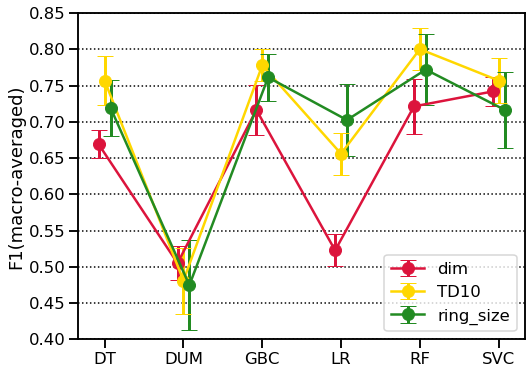

In [11]:
plt.figure(figsize=(8, 6))

for prop, colour, delta in zip(['dim', 'TD10', 'ring_size'],
                               ['crimson', 'gold', 'forestgreen'],
                               [-0.075, 0, 0.075]):

    plt.errorbar(x=np.arange(6) + delta, y=summary.loc[prop]['n5x5_cv_mean'],
                 yerr=summary.loc[prop]['n5x5_cv_std'],
                 marker='o', ms=12,
                 color=colour, lw=2.5,
                 ecolor=colour, elinewidth=3, capsize=8,
                 label=prop)
    plt.xticks(ticks=range(6), labels=['DT', 'DUM', 'GBC', 'LR', 'RF', 'SVC'])

plt.ylabel('F1(macro-averaged)')
plt.ylim(0.4, 0.85)
plt.legend(loc='best')
plt.grid(b=True, axis='y', ls=':', color='k', lw='1.5')
# plt.savefig('model_performance_nestedCV_Xtrue.png', dpi=dpi)

**Learning curves for model assesment on the data amount**


######################################################################

dim prediction

######################################################################



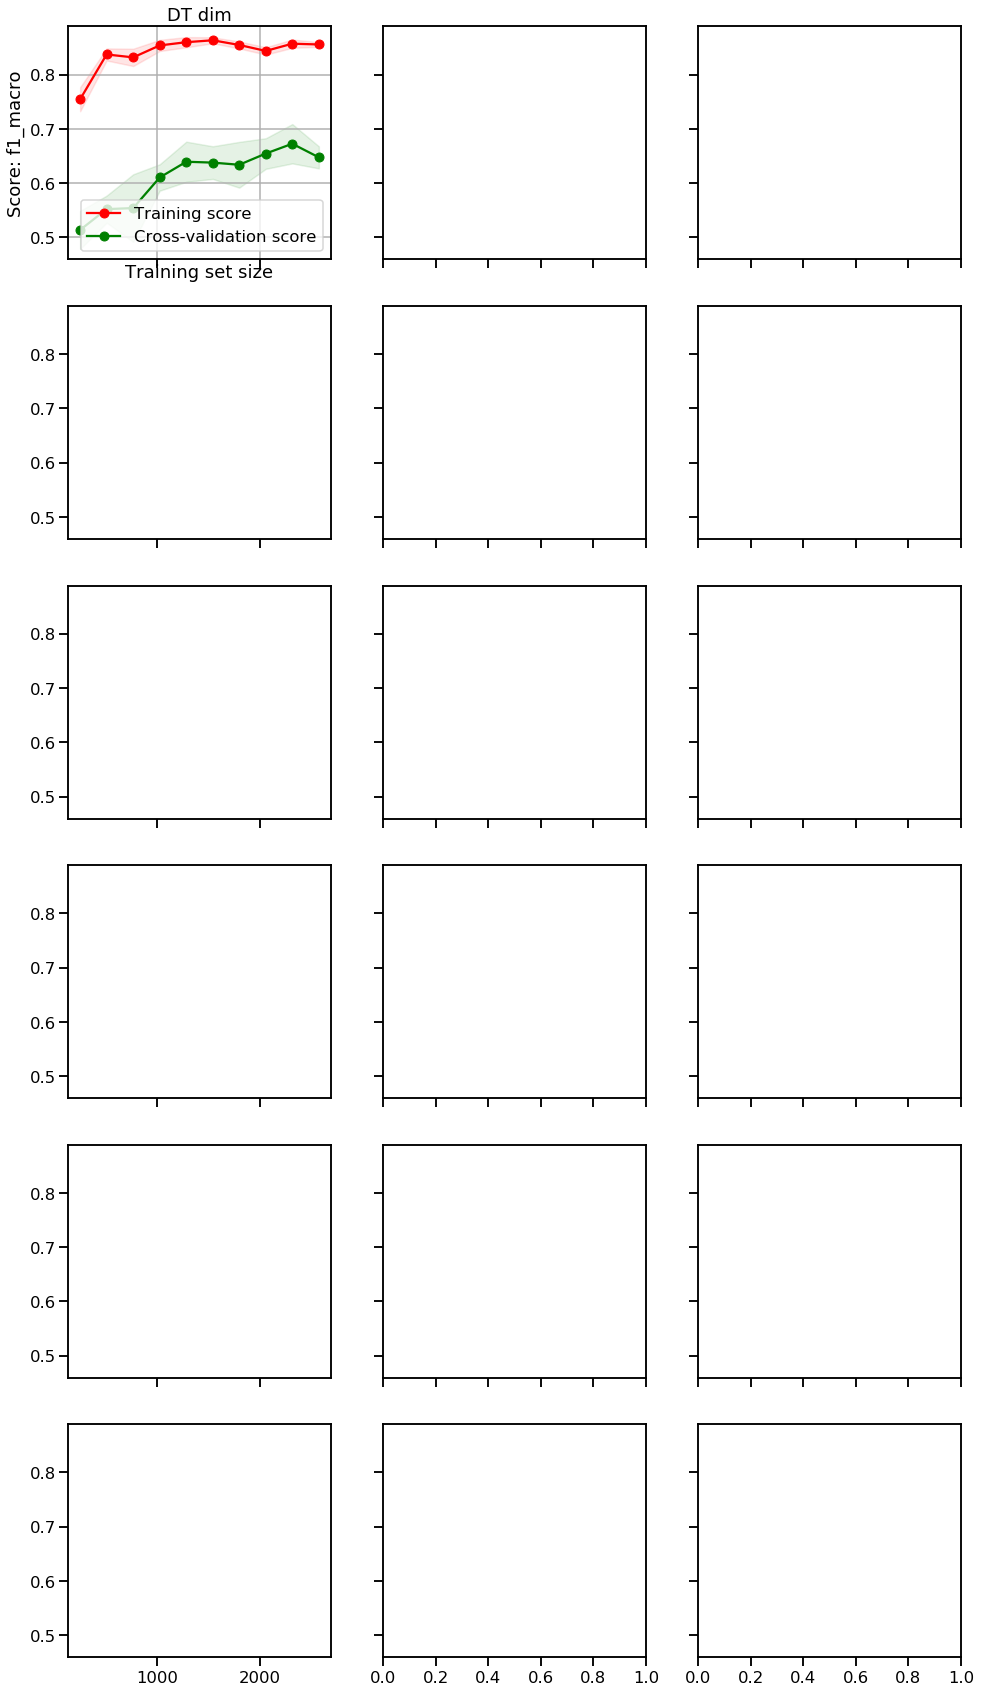


######################################################################

TD10 prediction

######################################################################


######################################################################

ring_size prediction

######################################################################



In [31]:
fig, ax = plt.subplots(6, 3, figsize=(16, 30), sharex='col', sharey=True)

for i, (frmwrk_prop, yx) in enumerate(zip(['dim', 'TD10', 'ring_size'], yXs)):

    print('\n%s\n' % (70*'#'))
    print(frmwrk_prop, 'prediction')
    print('\n%s\n' % (70*'#'))

    model_dict = model_dicts_loaded[frmwrk_prop]

    for j, (model_name, model) in enumerate(sorted(model_dict.items())):
        plot_learning_curve(estimator=model,
                            title=f'{model_name} {frmwrk_prop}',
                            axes=ax[j, i],
                            X=yx.iloc[:, 1:], y=yx.iloc[:, 0].astype(int),
                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=23),
                            scoring='f1_macro',
                            train_sizes=np.linspace(.1, 1.0, 10))

fig.tight_layout()
# fig.savefig('learning_curves.png', dpi=dpi)

**Results of learning curves analysis**
- `dim` - need more data to train - then better prediction quality, especially for `dim`! Note these are the datasets with high class imbalance
- `TD10`, `ring_size` - more data will only slightly improve model prediction abilities

## Analysis and interpretation of models 

### y-randomization test

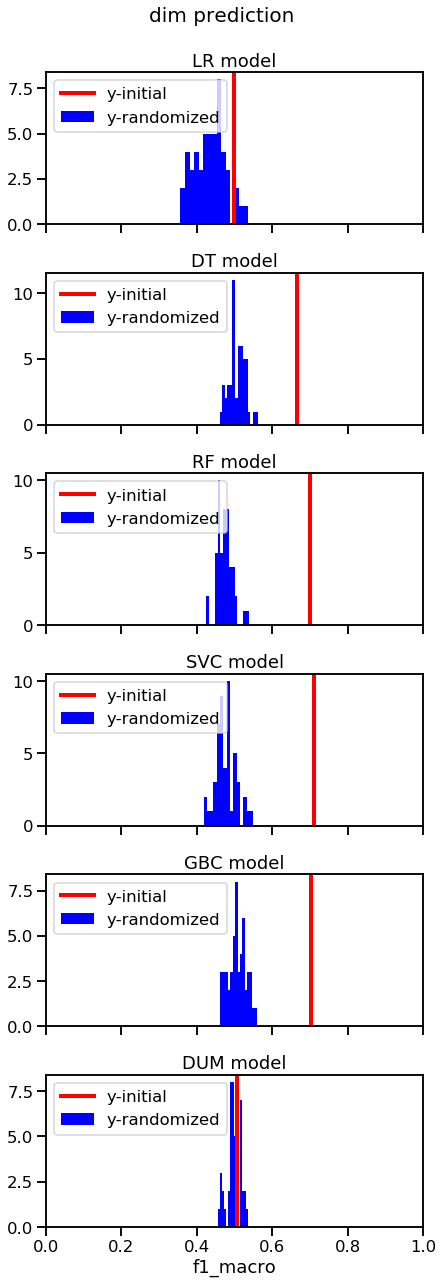

In [8]:
y_randomization_test(y1X, model_dicts_loaded, 'dim', scoring='f1_macro', n_repeats=50, savefig=True)

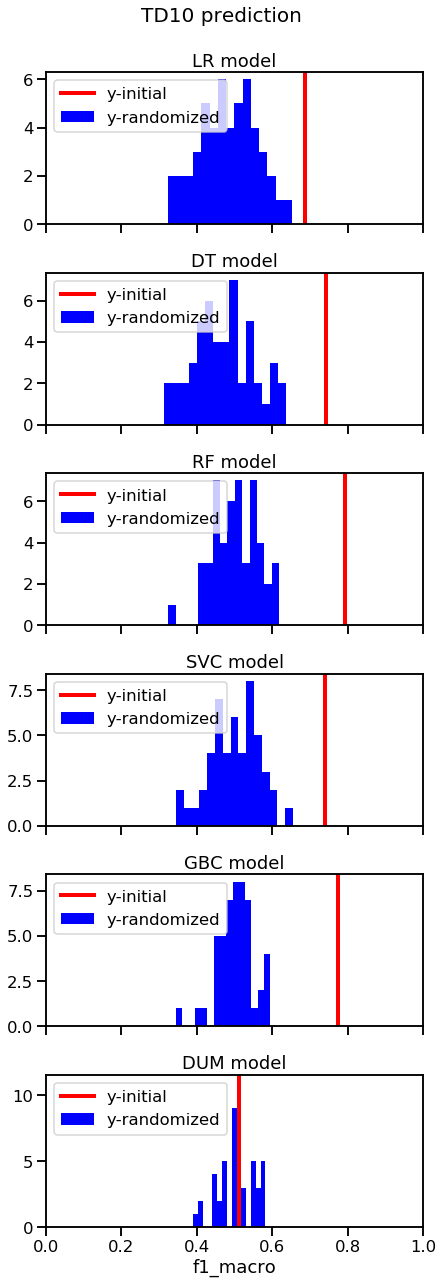

In [9]:
y_randomization_test(y2X, model_dicts_loaded, 'TD10', scoring='f1_macro', n_repeats=50, savefig=True)

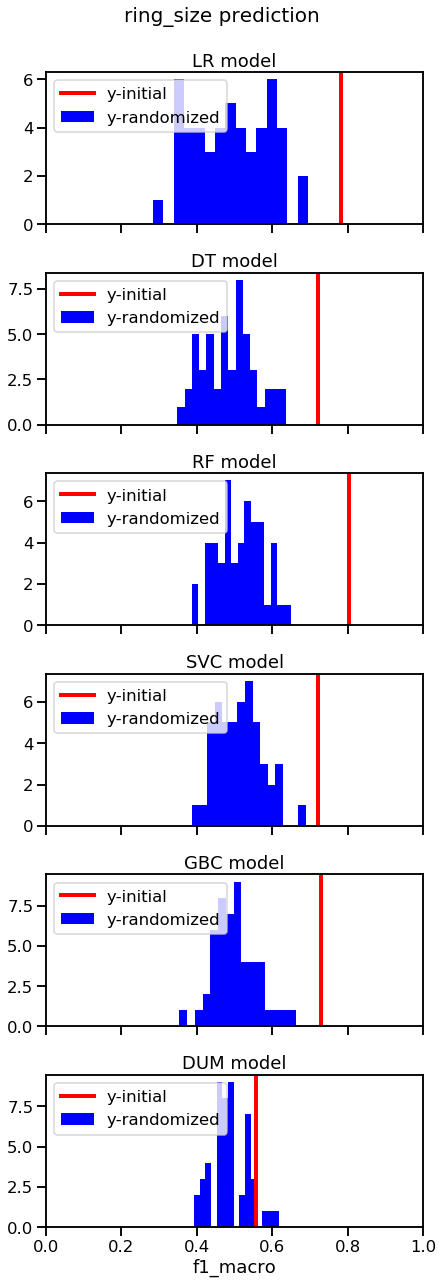

In [10]:
y_randomization_test(y4X, model_dicts_loaded, 'ring_size', scoring='f1_macro', n_repeats=50, savefig=True)

### permutation importance analysis

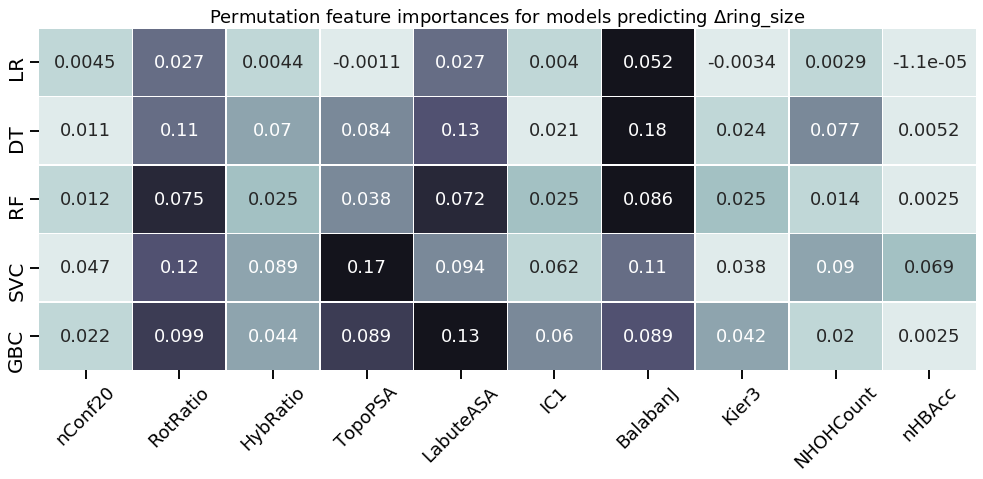

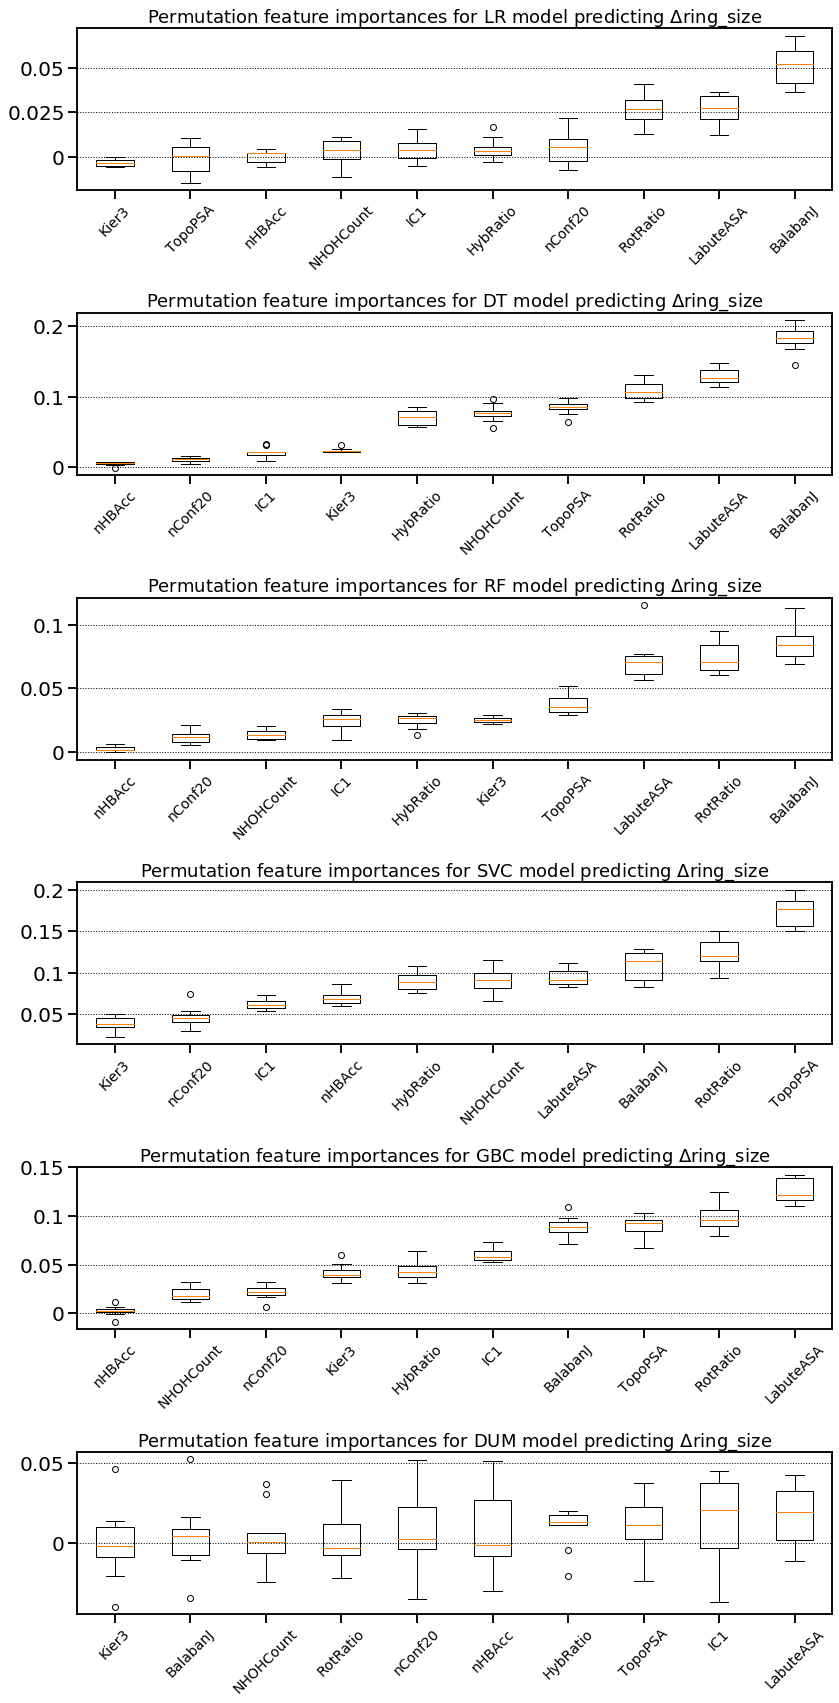

In [8]:
show_importances('ring_size', y4X, model_dicts_loaded, savefig=True)
show_importance_hists('ring_size', y4X, model_dicts_loaded, savefig=True) #

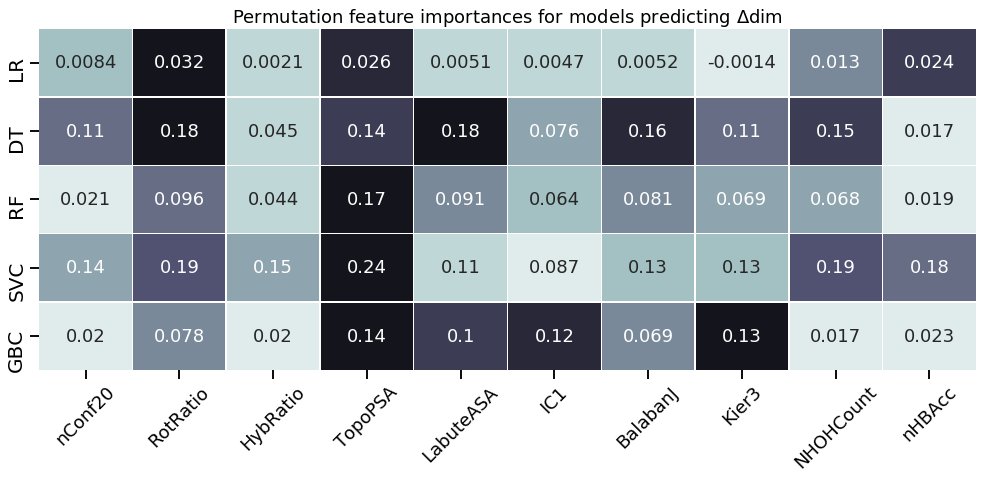

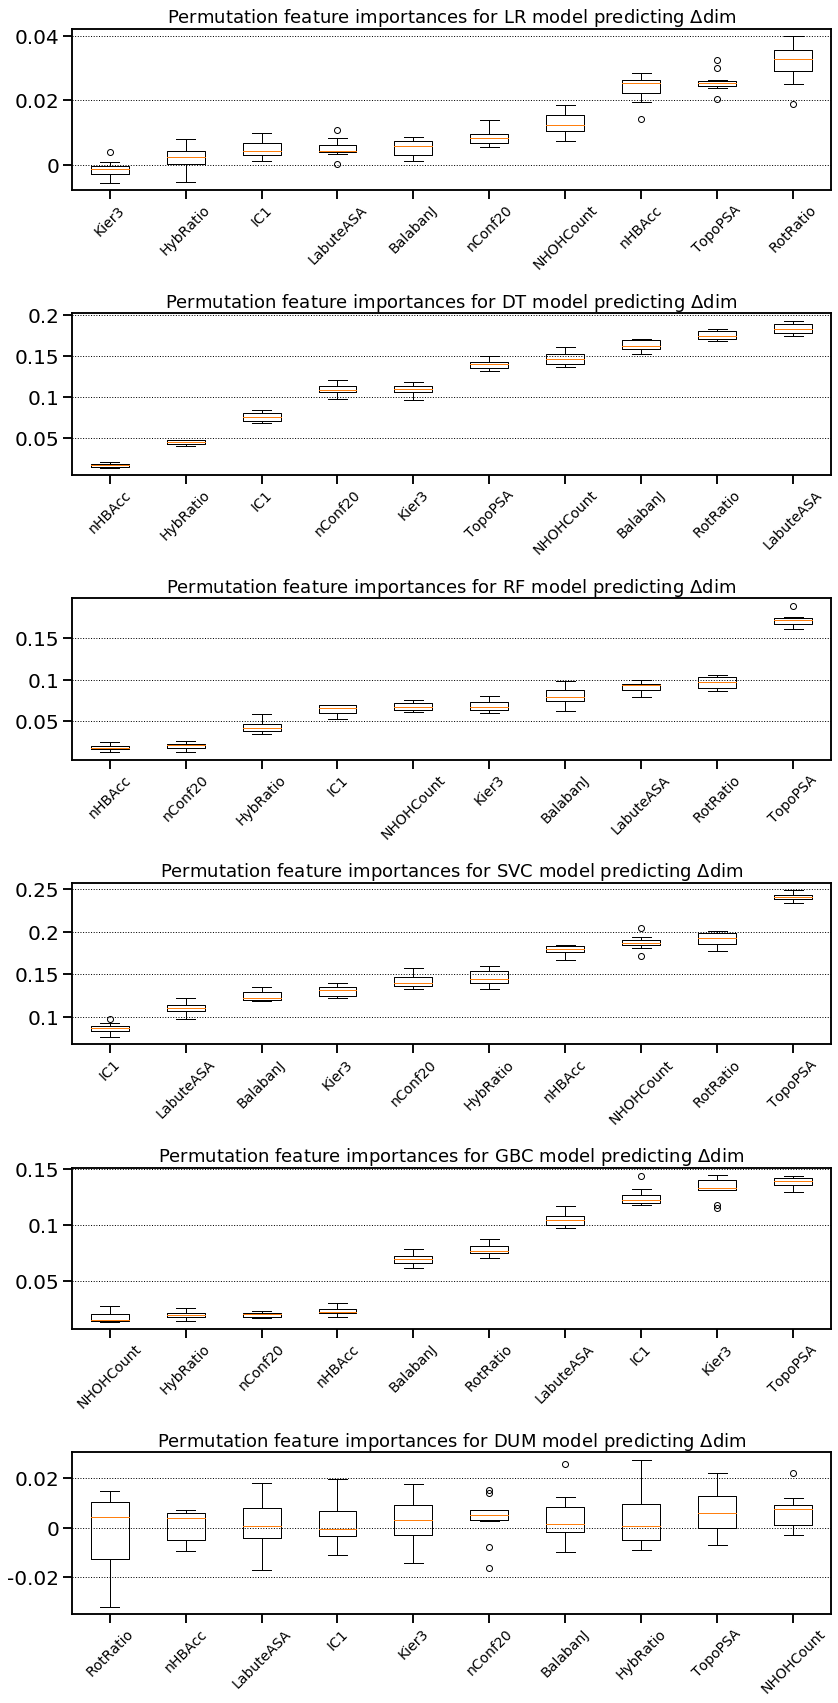

In [9]:
show_importances('dim', y1X, model_dicts_loaded, savefig=True)
show_importance_hists('dim', y1X, model_dicts_loaded, savefig=True) #

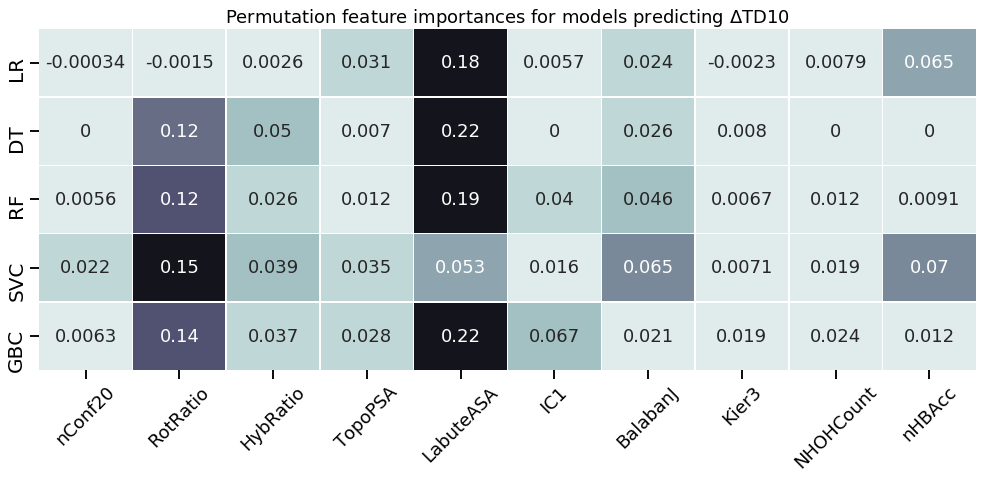

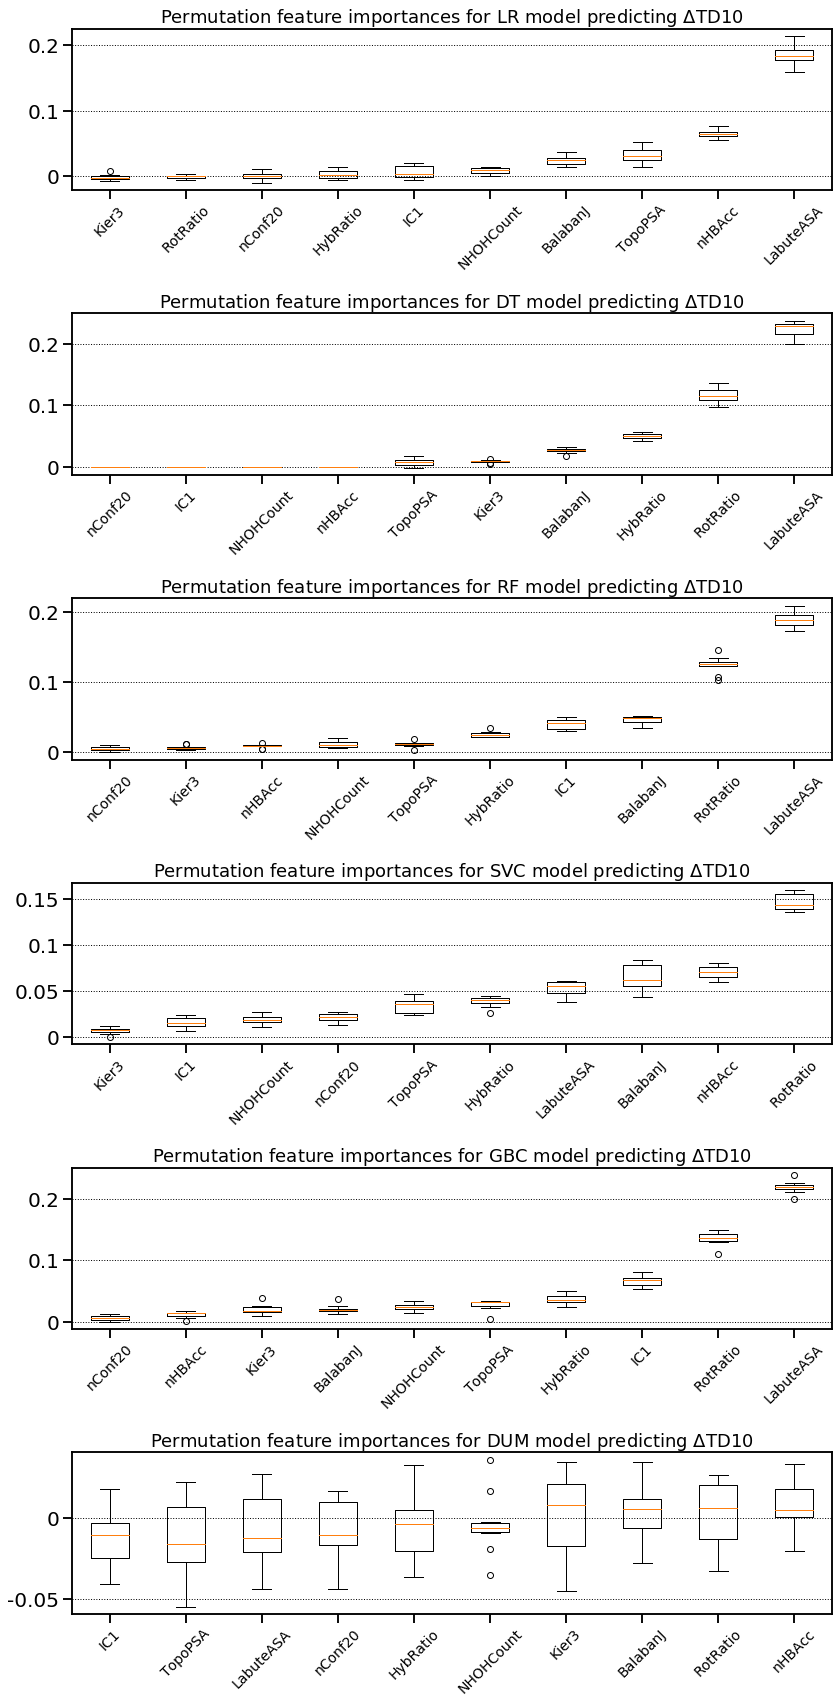

In [10]:
show_importances('TD10', y2X, model_dicts_loaded, savefig=True)
show_importance_hists('TD10', y2X, model_dicts_loaded, savefig=True) #

### TD10 prediction

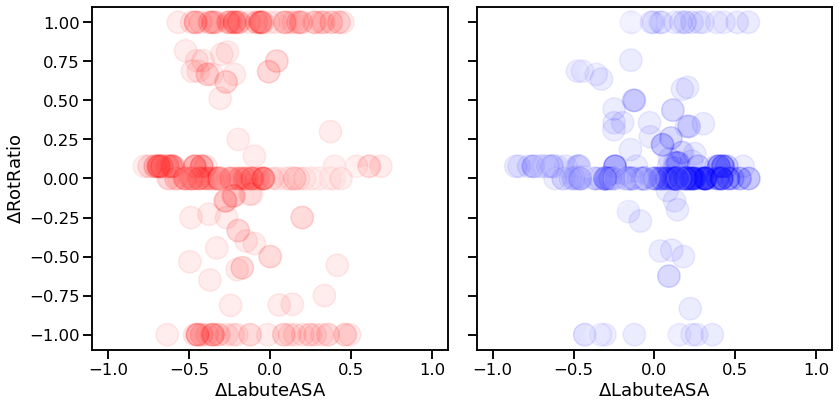

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

y2X.plot.scatter(x='LabuteASA', y='RotRatio',
                 s=500, alpha=.075,
                 c=['r' if y==1 else 'w' for y in y2X['TD10_mean']], ax=ax1)

y2X.plot.scatter(x='LabuteASA', y='RotRatio',
                 s=500, alpha=.075,
                 c=['b' if y==0 else 'w' for y in y2X['TD10_mean']], ax=ax2)

ax1.set_xlim(-1.1, 1.1)
ax1.set_ylabel('$\Delta$RotRatio')
ax1.set_xlabel('$\Delta$LabuteASA')
ax2.set_xlabel('$\Delta$LabuteASA')
ax2.set_xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

fig.tight_layout()
fig.savefig('LabuteASA_RotRatio_TD10_scatter.png', dpi=200)

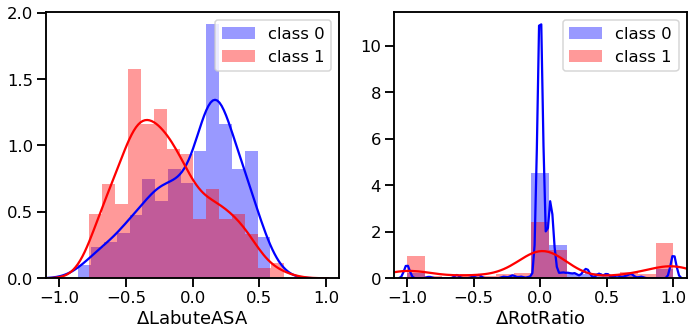

In [15]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
sns.distplot(y2X['LabuteASA'][y2X['TD10_mean']==0], color='b', bins=15, label='class 0')
sns.distplot(y2X['LabuteASA'][y2X['TD10_mean']==1], color='r', bins=15, label='class 1')
plt.xlim(-1.1, 1.1)
plt.xlabel('$\Delta$LabuteASA')
plt.legend()

plt.subplot(122)
sns.distplot(y2X['RotRatio'][y2X['TD10_mean']==0], color='b', bins=15, label='class 0')
sns.distplot(y2X['RotRatio'][y2X['TD10_mean']==1], color='r', bins=15, label='class 1')
plt.xlim(-1.1, 1.1)
plt.xlabel('$\Delta$RotRatio')
plt.legend()

plt.tight_layout()
plt.savefig('LabuteASA_RotRatio_TD10_dist.png', dpi=200)